# Chapter 2. Small Worlds and Large Worlds

https://fehiepsi.github.io/rethinking-numpyro/

## setup requirements
```
!pip install -q numpyro arviz causalgraphicalmodels daft
```

In [514]:
import os

import arviz as az
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

import scipy.special

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

cm=1/2.54 # centimeters in inches
px=1/plt.rcParams['figure.dpi'] # pixel in inches

%pprint # turn on/off pprint

Pretty printing has been turned OFF


In [74]:
# Code 2.1 generalized
FLOAT_F = 1
factory_count = jnp.array([0*FLOAT_F, 1, 1, 1, 0])
def post_fn(prio, likelihood): 
    t = prio * likelihood
    return t  / sum(t) # standardize the posterior, so it sums to 1

def likelihood(conjecture, marble): return (conjecture if marble == 'b' else 4 - conjecture)

# count of blue marbles
conjecture = [0, 1, 2, 3, 4]

prio = factory_count /sum(factory_count)
print("prio=", prio)
data = ['b', 'w', 'b', 'b' ] 

post = prio
for D in data:
    ways = jnp.array([likelihood(x, D) * FLOAT_F for x in conjecture])
    
    post = post_fn(post, ways)
    print("Murble=", D, "likelihood=", ways,  "posterior=>", post)

post


prio= [0.         0.33333334 0.33333334 0.33333334 0.        ]
Murble= b likelihood= [0 1 2 3 4] posterior=> [0.         0.16666667 0.33333334 0.5        0.        ]
Murble= w likelihood= [4 3 2 1 0] posterior=> [0.         0.29999998 0.4        0.29999998 0.        ]
Murble= b likelihood= [0 1 2 3 4] posterior=> [0.         0.14999999 0.4        0.45       0.        ]
Murble= b likelihood= [0 1 2 3 4] posterior=> [0.         0.06521739 0.3478261  0.5869565  0.        ]


DeviceArray([0.        , 0.06521739, 0.3478261 , 0.5869565 , 0.        ],            dtype=float32)

# Bayes Theorem : Posterior <pausibility of p after seeing Data> = Likelihood <ways p can produce Data> * Prio <prior plausibilyt p> / Data
- P(H1|D) = P(D|H1) * P(H1) / P(D)
- P(H2|D) = P(D|H2) * P(H2) / P(D)

- P(D) = P(D|H1)*P(H1) + P(D|H2)*P(H2)

# Earth: Water vs Land
### Data Story
- the true proportion of water covering the globe is p.
- a single toss of the globe has a probality p of producing a water (W) observation. It has a probability 1-p of producing land (L) observation.
- each toss of the globe is independent of the others.

[0 1 2 3 4 5 6 7 8 9]
0.0403536 1.9682979e-05
0.001953125 0.0019531241
1.9682997e-05 0.04035358


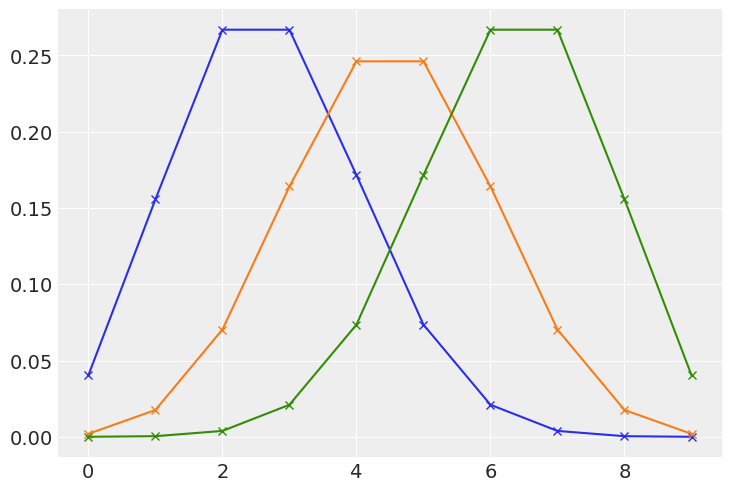

In [252]:
# Code 2.2
import scipy.special

N = 9
values = jnp.arange(0, N+1)
print(values)

for p in [0.3, 0.5, 0.7]:
    # classical binom pmf
    #   values_binom2 = scipy.special.binom(N, values) * (p ** values) * ((1-p) ** (N - values))
    
    # numpyro binom pmf
    values_binom = jnp.exp(dist.Binomial(total_count=N, probs=p).log_prob(values))
    print (values_binom[0], values_binom[N])
    plt.plot(values, values_binom, '-x')

<ipython-input-496-41df92d6d363>:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


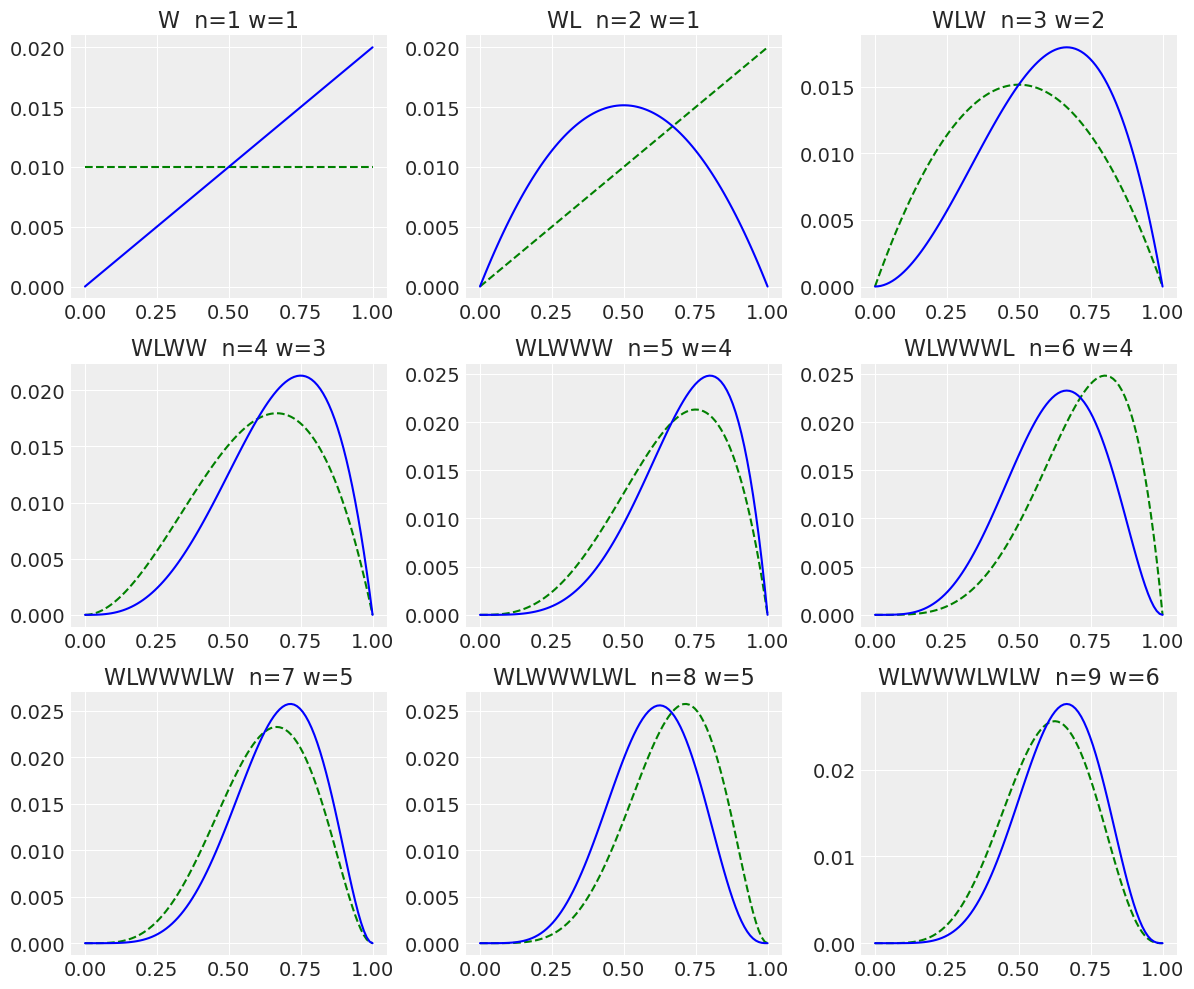

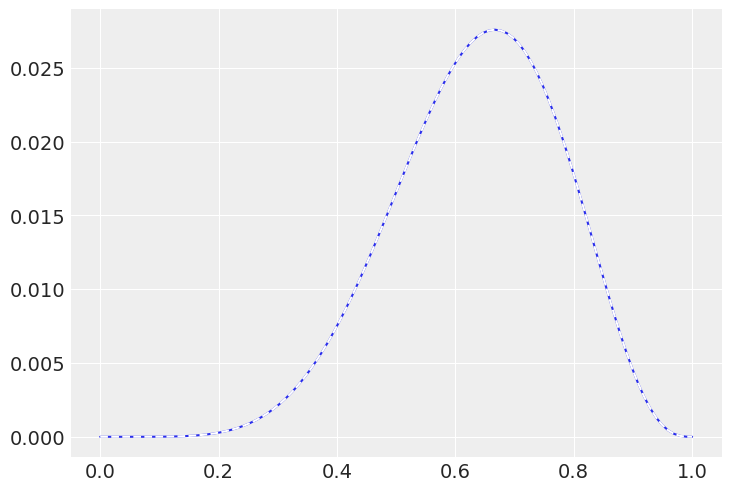

In [496]:
# generate figure 2.5

def posterior2_5(prior, success, p_grid):
    # Bin(1, p) is actualy Bern(p)
    # likelihood = jnp.exp(dist.Binomial(total_count=1, probs=p_grid).log_prob(success))
    likelihood = p_grid if success == 1 else (1 - p_grid)
    
    posterior = likelihood * prior
    posterior = posterior / jnp.sum(posterior)
    return posterior

p_grid = jnp.linspace(start=0, stop=1, num=100)
prior = jnp.repeat(1, len(p_grid))
prior = prior / sum(prior)

# compute posterior iterative
fig, _ = plt.subplots(1, 2, figsize=(12,10), sharey=True)
sequence="WLWWWLWLW"
for N in range(1, len(sequence)+1):
    W = len([x for x in sequence[0:N] if x == 'W'])
    
    posterior = posterior2_5(prior, 1 if sequence[N-1] == 'W' else 0, p_grid)
    plt.subplot(330 + N)
    
    plt.plot(p_grid, prior, 'g--')
    plt.plot(p_grid, posterior, 'b')
    #plt.ylabel("plausibility")
    plt.title("%s  n=%d w=%d" % (sequence[0:N], N, W))
    
    #print("prior(n=%d, w=%d)= %s" % (N, W, prior))
    #print("posterior=%s\n" % posterior)
    prior = posterior
    
fig.tight_layout()    
plt.show()

# compute posterior direct, same result
prior = jnp.repeat(1, len(p_grid))
prior = prior / sum(prior)

direct_likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
direct_posterior = direct_likelihood * prior
direct_posterior = direct_posterior / jnp.sum(direct_posterior)

plt.plot(p_grid, direct_posterior)
plt.plot(p_grid, posterior, 'w--')
plt.show()

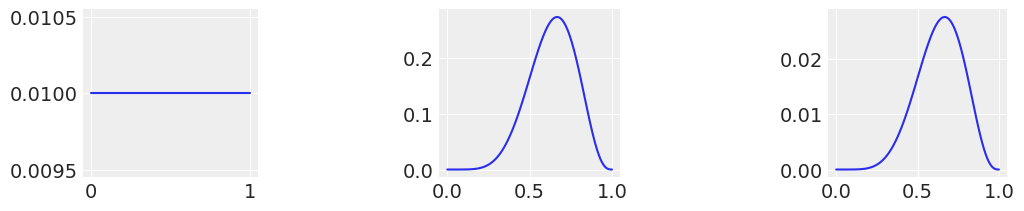

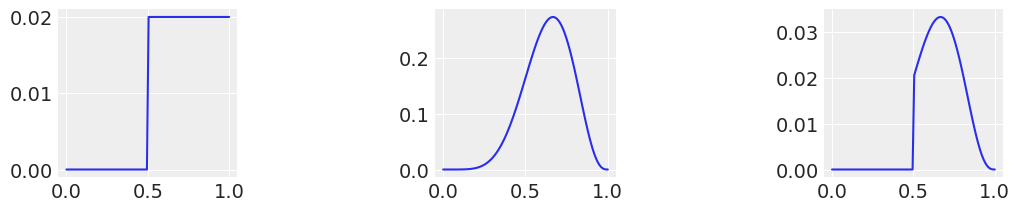

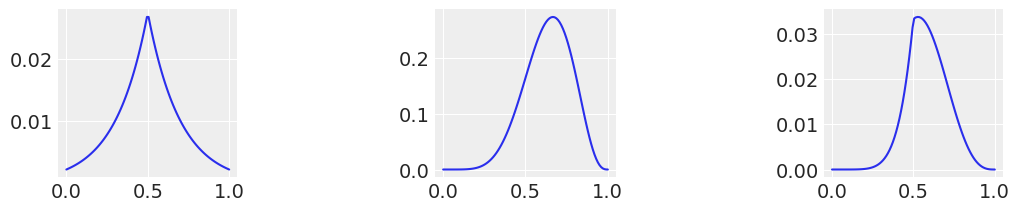

In [378]:
# generate figure 2.6

p_grid = jnp.linspace(start=0, stop=1, num=100)

def standardize(array): return array / jnp.sum(array)

def plot_row2_6(prior_fn, row):
    prior = standardize(prior_fn(p_grid))
    likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))
    posterior = standardize(likelihood * prior)
    
    plt.subplots(figsize=(12, 2))
    
    plt.subplot(162)
    plt.plot(p_grid, prior)
    
    plt.subplot(164)
    plt.plot(p_grid, likelihood)
    
    plt.subplot(166)
    plt.plot(p_grid, posterior)
    plt.show()
    
# prio ~ Unif(0, 1)
plot_row2_6(lambda p_grid: jnp.repeat(1, len(p_grid)), 1)

# uniform prior from [0.5, 1]
plot_row2_6(lambda p_grid: jnp.where(p_grid < 0.5, 0, 1), 2)

# exp prio 
plot_row2_6(lambda p_grid: jnp.exp(-5 * abs(p_grid - 0.5)), 3)

In [366]:
def plot_posterior(prior_fn):
    plt.subplots(figsize=(14,4))
    
    for points, subplot in [(5,    162), 
                            (20,   164), 
                            (100,  166)]:
        # define grid
        p_grid = jnp.linspace(start=0, stop=1, num=points)

        # define prior
        prior = prior_fn(p_grid)
        prior = prior / jnp.sum(prior) # standardize the prior, so it sum to 1

        # compute likelihood at each value in grid
        likelihood = jnp.exp(dist.Binomial(total_count=9, probs=p_grid).log_prob(6))

        # compute product of likelihood and prior
        unstd_posterior = likelihood * prior

        # standardize the posterior, so it sums to 1
        posterior = unstd_posterior / jnp.sum(unstd_posterior)
        
        # print("prior(n=%d, w=%d)= %s" % (2, 1, prior))
        # print("posterior=%s\n" % posterior)

        # Code 2.4
        plt.subplot(subplot)
        
        plt.plot(p_grid, prior, 'r-d')
        plt.plot(p_grid, posterior, 'b-x')
        plt.xlabel("probability of water")
        plt.ylabel("posterior probability")
        plt.title("%d points" % points)

    plt.show()    

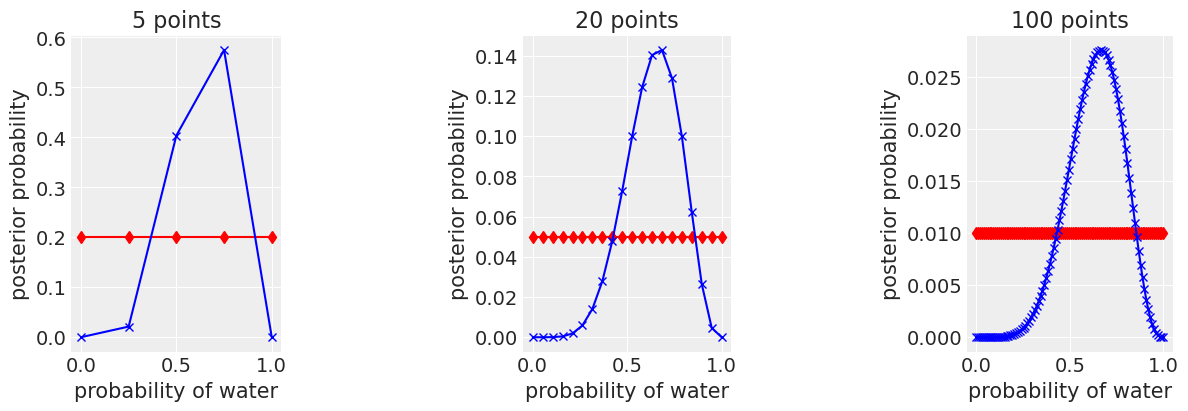

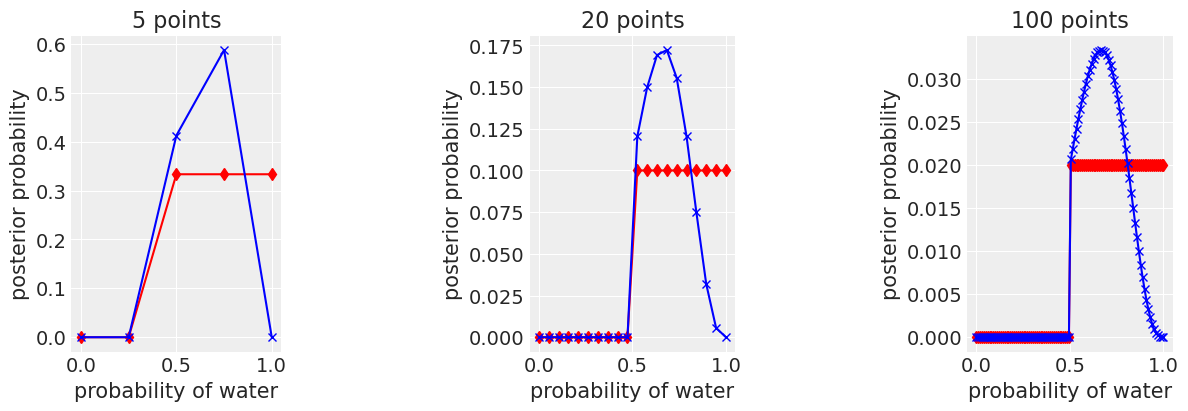

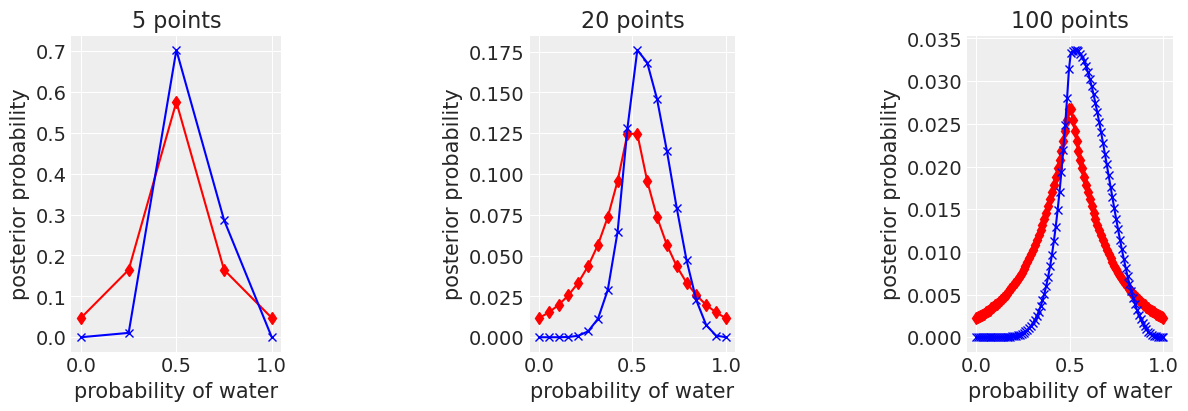

In [367]:
# Code 2.3 - uniform prior [0, 1]
plot_posterior(lambda p_grid: jnp.repeat(1, len(p_grid)))

# Code 2.5 - uniform prior from [0.5, 1]
plot_posterior(lambda p_grid: jnp.where(p_grid < 0.5, 0, 1))

# Code 2.6 - 
plot_posterior(lambda p_grid: jnp.exp(-5 * abs(p_grid - 0.5)))


In [387]:
# Code 2.6
def model(W, L):
    p = numpyro.sample("p", dist.Uniform(0, 1))  # uniform prior
    numpyro.sample("W", dist.Binomial(W + L, p), obs=W)  # binomial likelihood

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, optim.Adam(1), Trace_ELBO(), W=6, L=3)
svi_result = svi.run(random.PRNGKey(0), 1000)
params = svi_result.params

# display summary of quadratic approximation
samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
numpyro.diagnostics.print_summary(samples, prob=0.89, group_by_chain=False)


100%|██████████| 1000/1000 [00:00<00:00, 1508.62it/s, init loss: 2.9278, avg. loss [951-1000]: 2.7795]



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         p      0.62      0.14      0.63      0.41      0.84    845.27      1.00



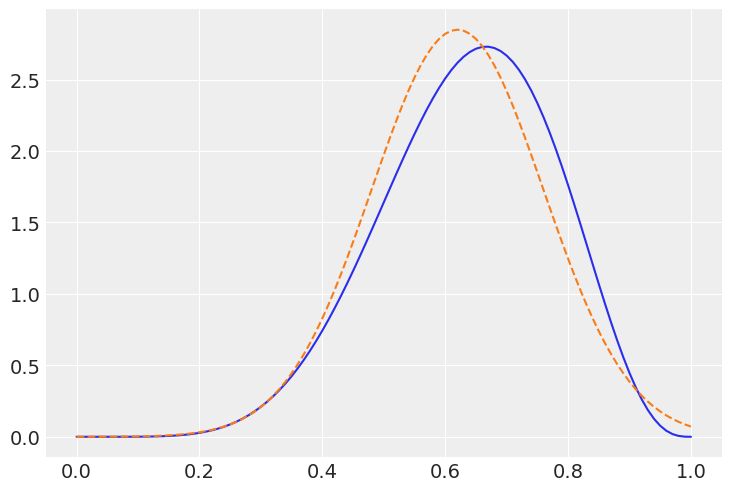

In [384]:
# Code 2.7
# analytical calculation
W = 6
L = 3
x = jnp.linspace(0, 1, 101)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)))
# quadratic approximation
plt.plot(x, jnp.exp(dist.Normal(0.62, 0.14).log_prob(x)), "--")
plt.show()

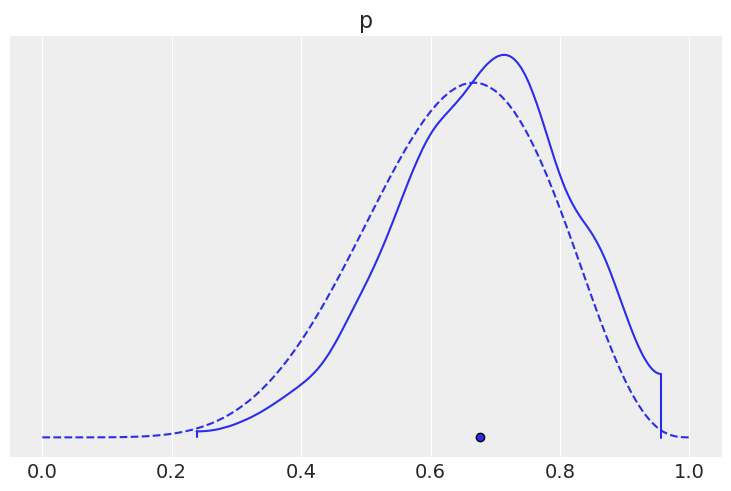

In [85]:
# Code 2.8
n_samples = 1000
p = [jnp.nan] * n_samples
p[0] = 0.5
W = 6
L = 3
with numpyro.handlers.seed(rng_seed=0):
    for i in range(1, n_samples):
        p_new = numpyro.sample("p_new", dist.Normal(p[i - 1], 0.1))
        p_new = jnp.abs(p_new) if p_new < 0 else p_new
        p_new = 2 - p_new if p_new > 1 else p_new
        q0 = jnp.exp(dist.Binomial(W + L, p[i - 1]).log_prob(W))
        q1 = jnp.exp(dist.Binomial(W + L, p_new).log_prob(W))
        u = numpyro.sample("u", dist.Uniform())
        p[i] = p_new if u < q1 / q0 else p[i - 1]
        
# Code 2.9
az.plot_density({"p": p}, hdi_prob=1)
plt.plot(x, jnp.exp(dist.Beta(W + 1, L + 1).log_prob(x)), "--")
plt.show()

# -------------------------------------------------------------
# Practice

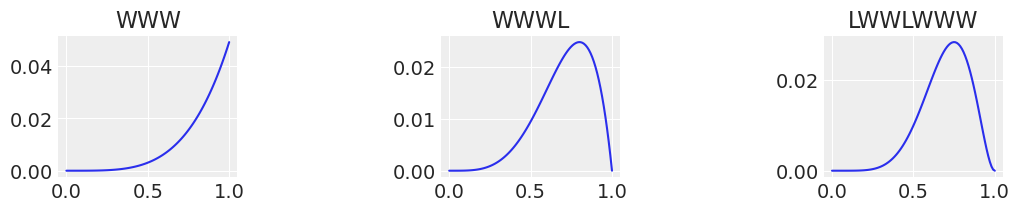

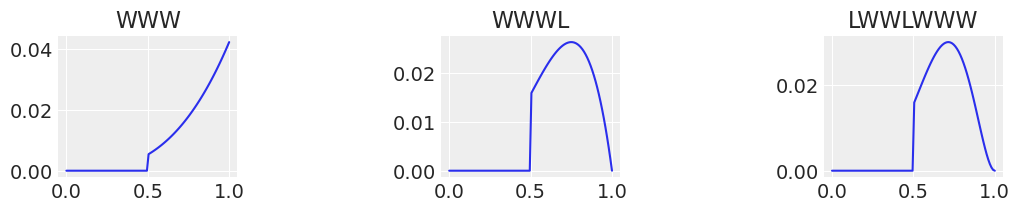

In [401]:
# 2M1 & 2M2
def standardize(array): return array / jnp.sum(array)

p_grid = jnp.linspace(start=0, stop=1, num=100)

def plot_posterior_2M1(prior, data, subplot):
    N = len(data)
    W = len([x for x in data if x == 'W'])
    
    likelihood = jnp.exp(dist.Binomial(total_count=N, probs=p_grid).log_prob(W))
    posterior = standardize(likelihood * prior)
    
    plt.subplot(subplot)
    plt.title(data)
    plt.plot(p_grid, posterior)

    
# 2M1
plt.subplots(figsize=(12, 2))
prior = standardize(p_grid)
plot_posterior_2M1(prior, "WWW", 161)
plot_posterior_2M1(prior, "WWWL", 163)
plot_posterior_2M1(prior, "LWWLWWW", 165)
plt.show()


# 2M2
plt.subplots(figsize=(12, 2))
prior = standardize(jnp.where(p_grid < 0.5, 0, 1))
plot_posterior_2M1(prior, "WWW", 161)
plot_posterior_2M1(prior, "WWWL", 163)
plot_posterior_2M1(prior, "LWWLWWW", 165)
plt.show()


In [427]:
# Simulate 2M4
## B/B, B/W, W/W
import numpy.random

(N_BB, N_BW) = (1, 1) # avoid divide by zero
for i in range(0, 1000):
    card = numpy.random.randint(0, 2)
    if card == 0: # B/B
        N_BB = N_BB + 1
    elif numpy.random.randint(0, 2) == 0: # Up is Black
        N_BW = N_BW + 1
    
print(N_BB/(N_BB + N_BW))
        
    

0.7272727272727273


In [441]:
# Simulate Prob(Sum of 2 dies = 11) > Prob(Sum of 2 dies = 12)
import numpy.random

Sum11, Sum12, N = (1, 1, 100000)

for i in range(0, N):
    die1 = numpy.random.randint(1, 7)
    die2 = numpy.random.randint(1, 7)
    if die1 + die2 == 12:
        Sum12 = Sum12 + 1
    elif die1 + die2 == 11:
        Sum11 = Sum11 + 1
        
print("P(Sum11)/P(Sum12) =", Sum11/Sum12)

P(Sum11)/P(Sum12) = 1.984424778761062


In [392]:
# 2M3

# P(land|Earth)=1 - p(water|Earth)
P_land_given_Earth = 1 - 0.7 
# P(land|Mars)=1
P_land_given_Mars = 1

# P(land) = P(land|Earth) x P(Earth) + P(land|Mars) x p(Mars)
P_land = P_land_given_Earth * 0.5 + P_land_given_Mars * 0.5
# P(Earth|land) = P(land|Earth) x P(Earth) / P(land)

P_Earth_given_land = P_land_given_Earth * 0.5 / P_land
print(P_Earth_given_land)


0.23076923076923078
